# Course Project 
<p>
Author  - Vazgen Tadevosyan <br></p>

For the course project, we will investigate the problem of predicting readmission of hospital patients. Readmission of patients following discharge from hospital places an enormous and very expensive burden on the US healthcare system (estimated at $40B in 2011)<br>
Besides administration of hospitals might also be concerned what facors make cause readmission.
Keeping that in mind I will try to present feature importances as well.



* [Feature Engineering](#second-bullet)
    1. Depending on the classification technique, selecting a subset of features based on exploratory
       analysis.
    2. Using domain knowledge to select or construct appropriate features

* [Building models and evaluating techniques](#second-bullet)
    1. Tuning hyperparameters of, and rigorously evaluating my choses model
    2. I may need to try out multiple methods and compare them.


In [3]:
# 
import re

#for not showing warnings
import warnings
warnings.filterwarnings('ignore')


#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for modelling and evaluation
from scipy import stats
from sklearn.metrics import  roc_curve
from sklearn.tree import export_graphviz
roc_curve
from  sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.linear_model import  LogisticRegression
from statsmodels.discrete.discrete_model import Logit 
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
#in case of error run <<!pip install>> and run the code again

In [4]:
train_data = pd.read_csv('cleaned_train.csv')
test_data = pd.read_csv('cleaned_test.csv')

In [5]:
x_train = train_data.drop('readmitted',1)
y_train = train_data['readmitted']
x_test = test_data.drop('readmitted',1)
y_test = test_data['readmitted']

In [6]:
train_numerics = x_train.select_dtypes(exclude="object")
train_objects  = x_train.select_dtypes(include="object")#
train_dummies  =  pd.get_dummies(train_objects,columns=train_objects.columns,drop_first=True)


test_numerics = x_test.select_dtypes(exclude="object")
test_objects  = x_test.select_dtypes(include="object")#
test_dummies  = pd.get_dummies(test_objects,columns=test_objects.columns,drop_first=True)


new=train_dummies.join(train_numerics)

In [7]:
# we might have categorical values in test not seen in training. Let's check that
for i in test_dummies.columns:
    if i not in train_dummies.columns:
        print(i)

In [8]:
for i in train_dummies.columns:
    if i not in test_dummies.columns:
        print(i)

admission_type_not_applicable
dischargeDisposition_Discharged_transferred_to_SNF
dischargeDisposition_Discharged_transferred_to_another_short_term_hospital
dischargeDisposition_Discharged_transferred_to_home_with_home_health_service
dischargeDisposition_Other
dischargeDisposition_not_applicable
admission_source_Other
admission_source_Physician_Referral
admission_source_not_applicable


Let's handle these issue so as not to have errors while applying our model to test dataset

In [9]:
train_dummies = train_dummies[train_dummies.columns.intersection(test_dummies.columns)]

In [10]:
#it is already ok
for i in train_dummies.columns:
    if i not in test_dummies.columns:
        print(i)

While it is technically possible to use PCA on discrete variables, or categorical variables that have been one hot encoded variables, you should not. ... The only way PCA is a valid method of feature selection is if the most important variables are the ones that happen to have the most variation in them .[Link](https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6#:~:text=While%20it%20is%20technically%20possible,encoded%20variables%2C%20you%20should%20not.&text=The%20only%20way%20PCA%20is,the%20most%20variation%20in%20them%20.)

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


scaler = StandardScaler()
transformed_train_numeric = pd.DataFrame(scaler.fit_transform(train_numerics),columns=train_numerics.columns)
transformed_test_numeric = pd.DataFrame(scaler.transform(test_numerics),columns=train_numerics.columns)
pca = PCA(n_components=4)

[0.25509586 0.17159908 0.1224078  0.11897799]


Text(0, 0.5, 'Cumulative explained variance')

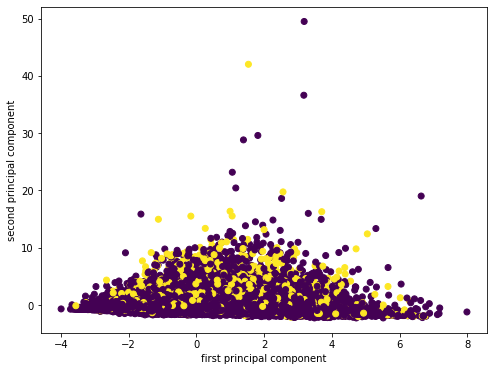

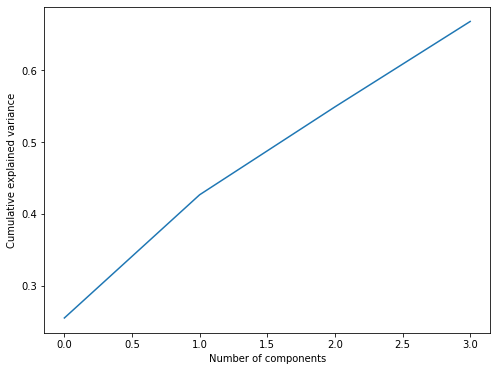

In [12]:

pca_transformed = pca.fit_transform(transformed_train_numeric)


plt.figure(figsize=(8,6))
plt.scatter(pca_transformed[:,0],pca_transformed[:,1], c=y_train)
plt.xlabel('first principal component')
plt.ylabel('second principal component')

print(pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

From now on there is no point to continue PCA as it could not explain variance,
for components explained 0.66 varaince using 8 features moreover, 8 numeric features is not too big to use PCA

## Multicolinearity

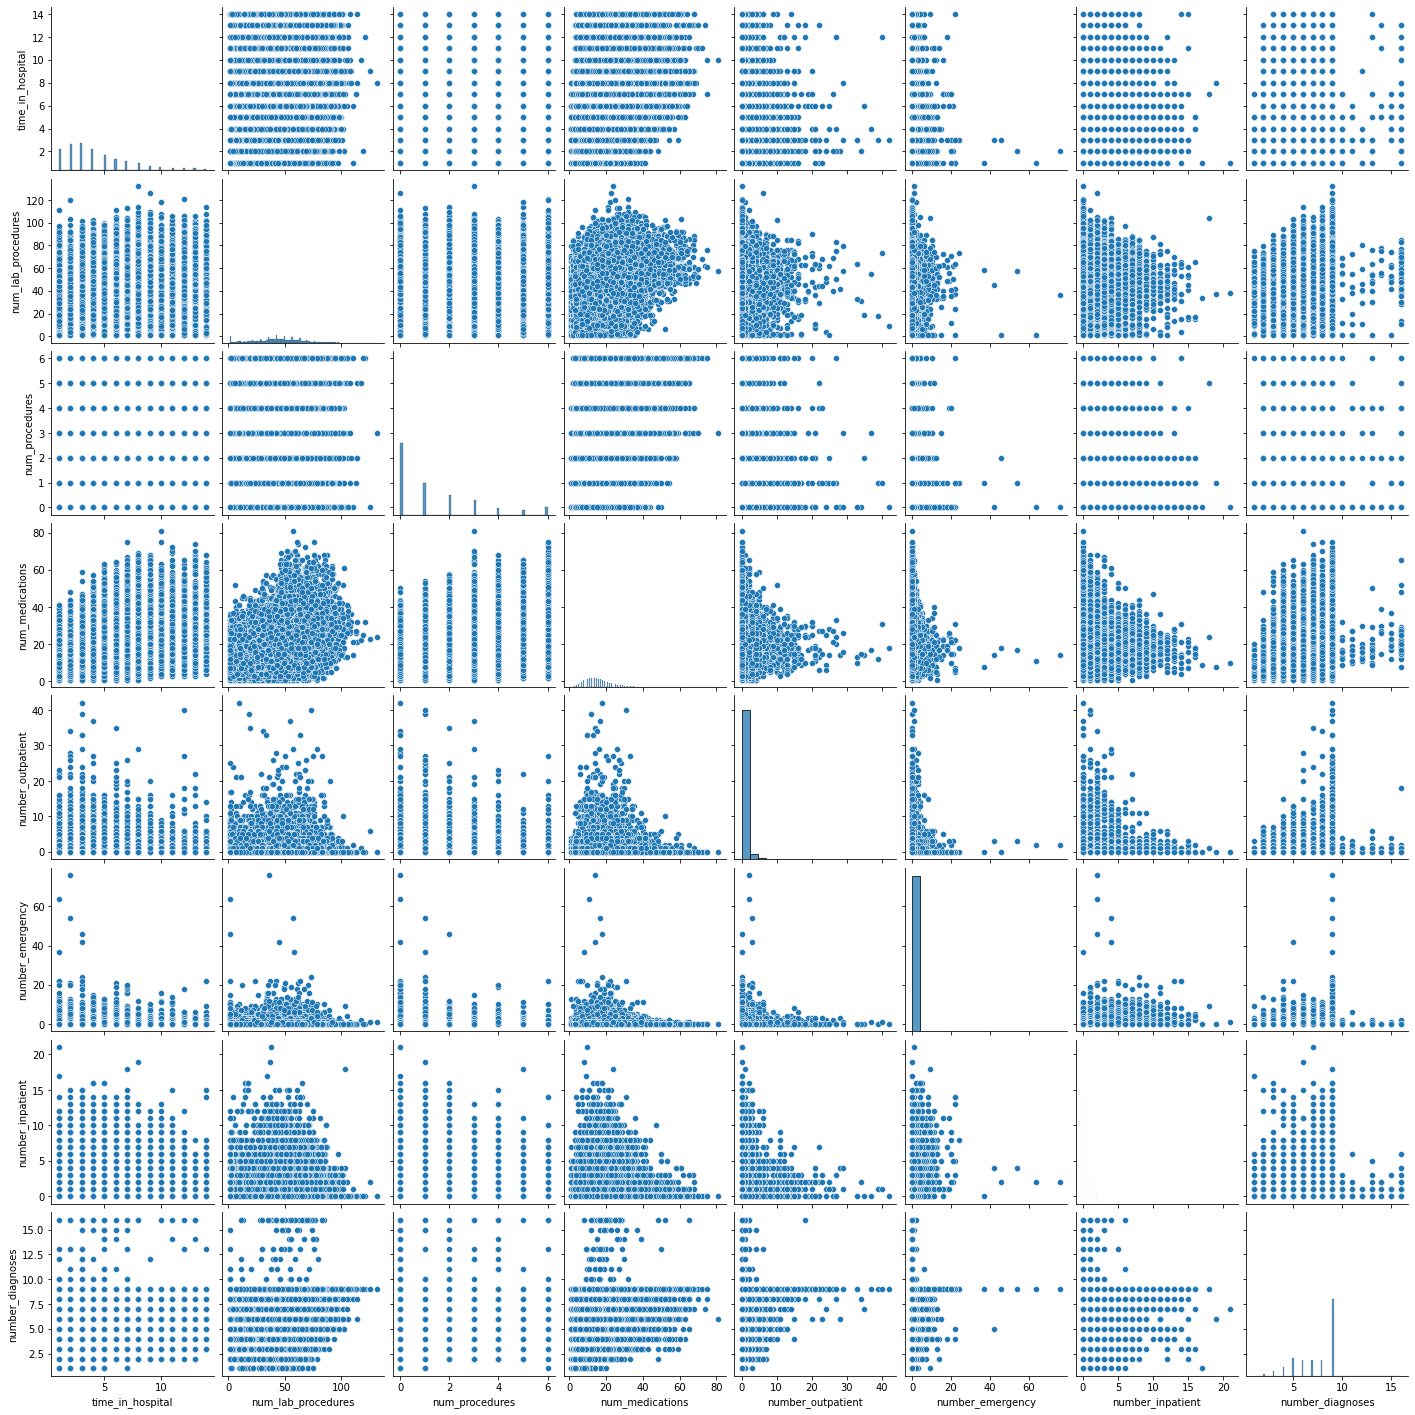

In [13]:
sns.pairplot(train_numerics)

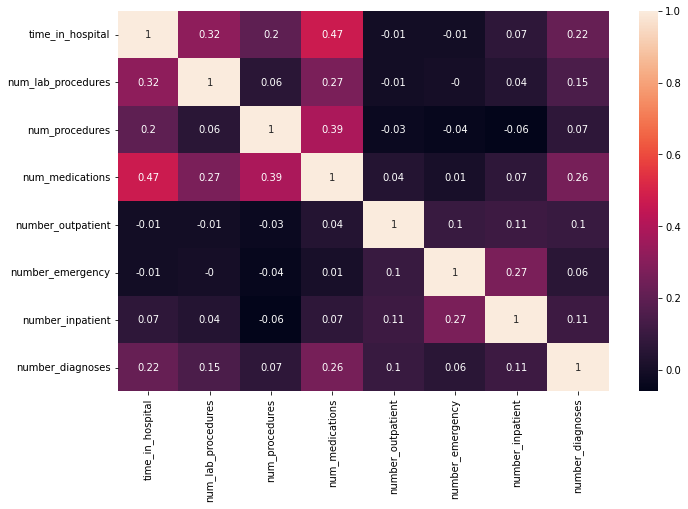

In [14]:
plt.figure(figsize=(11,7))
sns.heatmap(train_numerics.corr().round(2),annot=True)
plt.show()

We don't have multicolinearity issue here

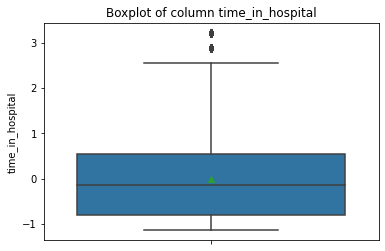

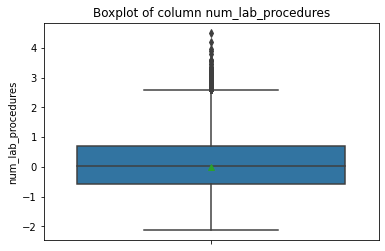

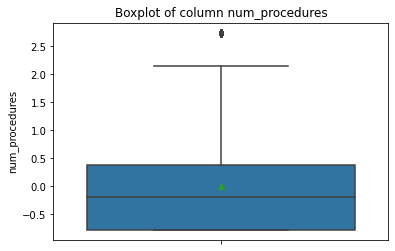

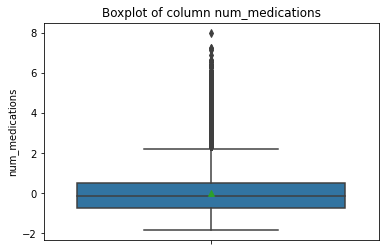

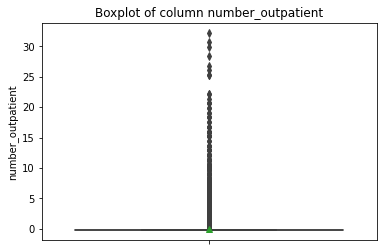

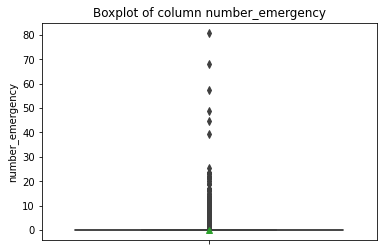

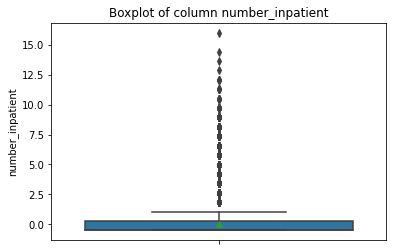

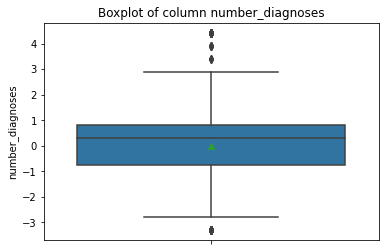

In [12]:
for i in transformed_train_numeric:
    sns.boxplot(data=transformed_train_numeric,y=i,showmeans=True,fliersize=5)
    plt.title("Boxplot of column %s"% i)
    plt.show()

As you see we have many outliers, this might cause problems.

we can use winsorization, it is a transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers, it replace otuliers by max or min depending on which critical region the outlier is. The distribution of many statistics can be heavily influenced by outliers. A typical strategy is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms, although there are alternatives, such as trimming, that will achieve a similar effect.
[Link](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0)

In [13]:
z=transformed_train_numeric.copy() ## now lets count number of outliers in each column####
Q1 = z.quantile(0.25)
Q3 = z.quantile(0.75)
IQR = Q3 - Q1
((z < (Q1 - 1.5 * IQR)) | (z > (Q3 + 1.5 * IQR))).sum()
mask = (z < (Q1 - 1.5 * IQR)) | (z > (Q3 + 1.5 * IQR))
z[mask] = np.nan
z.dropna().shape
## now lets count number of outliers in each columns
Q1 = transformed_train_numeric.quantile(0.25)#############
Q3 = transformed_train_numeric.quantile(0.75)
IQR = Q3 - Q1
((transformed_train_numeric < (Q1 - 1.5 * IQR)) | (transformed_train_numeric > (Q3 + 1.5 * IQR))).sum()

time_in_hospital       1695
num_lab_procedures      157
num_procedures         3684
num_medications        2210
number_outpatient     12606
number_emergency       8660
number_inpatient       5351
number_diagnoses        219
dtype: int64

In [14]:
colums_with_outliers=((transformed_train_numeric < (Q1 - 1.5 * IQR)) | (transformed_train_numeric > (Q3 + 1.5 * IQR))).sum()
colums_with_outliers=colums_with_outliers[colums_with_outliers>0].index.tolist()
colums_with_outliers##we do this to have names of columns where we have outliers

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [15]:
corrected=transformed_train_numeric.copy(deep=True)
for i in  colums_with_outliers:
    corrected[i]=stats.mstats.winsorize(np.array(transformed_train_numeric[i]),inplace=True,limits=0.05)

In [16]:
X_winsorized = corrected.join(train_dummies)
X_train_scaled = transformed_train_numeric.join(train_dummies)
X = train_numerics.join(train_dummies)

X_test_scaled = transformed_test_numeric.join(test_dummies)
X_test = test_numerics.join(test_dummies)

Logistic Regression

In [17]:
y_train.shape

(76321,)

In [21]:
import time

Time is1.5513005256652832
{'C': 0.50005, 'penalty': 'l2'}
Train score is 0.65992321903539 and Test score is0.6646490055813222
cross_validation score is 0.6599493899185666
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     22603
           1       0.17      0.51      0.25      2839

    accuracy                           0.66     25442
   macro avg       0.54      0.60      0.52     25442
weighted avg       0.83      0.66      0.72     25442

roc_auc: for test is 0.5973616110489904
roc_auc: for train is 0.5954475208738109
average Roc_score is 0.6357700111856907
recall for train 0.5124442357360883
recall for test 0.510743219443466


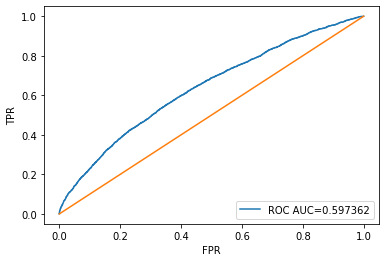

In [22]:
Y1=y_train
X1=X
grid1=GridSearchCV(LogisticRegression(random_state=42,class_weight="balanced"),
                   param_grid={"C":np.linspace(0.0001,1,25),"penalty":["l1","l2"]},scoring="roc_auc",cv=5,n_jobs=-1)
grid1.fit(X1,Y1)
params=list(grid1.best_params_.values())
C,Penalty=params

start_time = time.time()

logit1=LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced').fit(X1,Y1)
end_time = time.time()

logit_excecution_time = end_time-start_time

print(f"Time is{logit_excecution_time}")
train_score=logit1.score(X1,Y1)
test_score=logit1.score(X_test,y_test)
print(grid1.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced'),X1,Y1,cv=5))))
y_pred_test=logit1.predict(X_test)
y_pred_train=logit1.predict(X1)
print(classification_report(y_test,logit1.predict(X_test)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred_test))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred_train))
print("average Roc_score is",grid1.best_score_)
print("recall for train",recall_score(y_train,y_pred_train))
print("recall for test",recall_score(y_test,y_pred_test))
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,logit1.predict_proba(X_test)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred_test))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Time is 1.5513005256652832
{'C': 0.0417625, 'penalty': 'l2'}
Train score is 0.661574140800042 and Test score is0.6642166496344627
cross_validation score is 0.6601721156493836
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     22603
           1       0.17      0.51      0.25      2839

    accuracy                           0.66     25442
   macro avg       0.54      0.60      0.52     25442
weighted avg       0.83      0.66      0.72     25442

roc_auc: for test is 0.5966562883352334
roc_auc: for train is 0.5949909104548936
average Roc_score is 0.635862591566999
recall for train 0.509274477576896
recall for test 0.5096865093342726


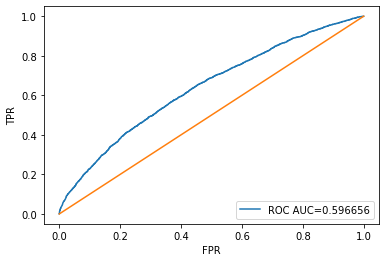

In [23]:
Y1=y_train
X1=X_train_scaled
grid1=GridSearchCV(LogisticRegression(random_state=42,class_weight="balanced"),
                   param_grid={"C":np.linspace(0.0001,1,25),"penalty":["l1","l2"]},scoring="roc_auc",cv=5,n_jobs=-1)
grid1.fit(X1,Y1)
params=list(grid1.best_params_.values())
C,Penalty=params

start_time = time.time()

logit1=LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced').fit(X1,Y1)
end_time = time.time()

logit_scaled_excecution_time = end_time-start_time

print(f"Time is {logit_excecution_time}")
train_score=logit1.score(X1,Y1)
test_score=logit1.score(X_test_scaled,y_test)
print(grid1.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced'),X1,Y1,cv=5))))
y_pred_test=logit1.predict(X_test_scaled)
y_pred_train=logit1.predict(X1)
print(classification_report(y_test,logit1.predict(X_test_scaled)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred_test))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred_train))
print("average Roc_score is",grid1.best_score_)
print("recall for train",recall_score(y_train,y_pred_train))
print("recall for test",recall_score(y_test,y_pred_test))
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,logit1.predict_proba(X_test_scaled)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred_test))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Time is 1.5355675220489502
{'C': 0.0417625, 'penalty': 'l2'}
Train score is 0.6627795757393116 and Test score is0.6558839713858974
cross_validation score is 0.6613645185922223
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     22603
           1       0.17      0.52      0.25      2839

    accuracy                           0.66     25442
   macro avg       0.54      0.60      0.51     25442
weighted avg       0.83      0.66      0.72     25442

roc_auc: for test is 0.5962785724033273
roc_auc: for train is 0.5985435420434095
average Roc_score is 0.6366616630097981
recall for train 0.5158487907959615
recall for test 0.5195491370200775


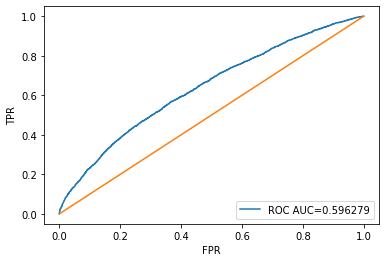

In [29]:
Y1=y_train
X1=X_winsorized
grid1=GridSearchCV(LogisticRegression(random_state=42,class_weight="balanced"),
                   param_grid={"C":np.linspace(0.0001,1,25),"penalty":["l1","l2"]},scoring="roc_auc",cv=5,n_jobs=-1)
grid1.fit(X1,Y1)
params=list(grid1.best_params_.values())
C,Penalty=params

start_time = time.time()

logit1=LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced').fit(X1,Y1)
end_time = time.time()

logit_excecution_time_winsorized = end_time-start_time

print(f"Time is {logit_excecution_time}")
train_score=logit1.score(X1,Y1)
test_score=logit1.score(X_test_scaled,y_test)
print(grid1.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(LogisticRegression(random_state=42,C=C,penalty=Penalty,class_weight='balanced'),X1,Y1,cv=5))))
y_pred_test=logit1.predict(X_test_scaled)
y_pred_train=logit1.predict(X1)
print(classification_report(y_test,logit1.predict(X_test_scaled)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred_test))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred_train))
print("average Roc_score is",grid1.best_score_)
print("recall for train",recall_score(y_train,y_pred_train))
print("recall for test",recall_score(y_test,y_pred_test))
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,logit1.predict_proba(X_test_scaled)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred_test))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# Random Forest

In [34]:
Y1=y_train
X1=X_winsorized
grid1 = GridSearchCV(RandomForestClassifier(random_state=42,class_weight="balanced"),
             param_grid={"max_depth":range(10,50),
                         "min_samples_leaf":range(40,150,25) },scoring="roc_auc",cv=5,n_jobs=-1).fit(X1,Y1)
params=list(grid1.best_params_.values())

max_depth,min_samples_leaf=params
x_test,y_test=X_test_scaled,y_test
start_time = time.time()
forest=RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=max_depth,min_samples_leaf=max_depth).fit(X1,y_train)

end_time = time.time()
forest_excecution_time_winsorized = end_time-start_time

print(f"Time is {forest_excecution_time_winsorized}")



[18, 65]
Time is 5.5502753257751465


{'max_depth': 18, 'min_samples_leaf': 65}
Train score is 0.8065014871398436 and Test score is0.7601210596651207
cross_validation score is 0.6774412793616067
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     22603
           1       0.20      0.37      0.26      2839

    accuracy                           0.76     25442
   macro avg       0.55      0.59      0.56     25442
weighted avg       0.83      0.76      0.79     25442

roc_auc: for test is 0.58980245369493
roc_auc: for train is 0.7392771502300229
average Roc_score is 0.641217311630218
recall for train 0.6527353838929326
recall for test 0.3705530116238112


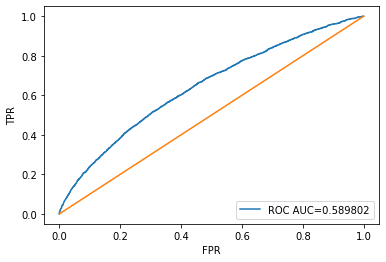

In [37]:

train_score=forest.score(X1,Y1)
test_score=forest.score(x_test,y_test)
print(grid1.best_params_)
print("Train score is %s and Test score is%s"%(train_score,test_score))
print("cross_validation score is %s"% (np.mean(cross_val_score(RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=max_depth,min_samples_leaf=min_samples_leaf),X1,Y1,cv=5))))
y_pred=forest.predict(x_test)
y_pred2=forest.predict(X1)
print(classification_report(y_test,forest.predict(x_test)))
print("roc_auc: for test is",roc_auc_score(y_test,y_pred))
print("roc_auc: for train is",roc_auc_score(y_train,y_pred2))
print("average Roc_score is",grid1.best_score_)
print("recall for train",recall_score(y_train,y_pred2))
print("recall for test",recall_score(y_test,y_pred))

#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,forest.predict_proba(X_test_scaled)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()






In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76321 entries, 0 to 76320
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   race                  76321 non-null  object 
 1   gender                76321 non-null  object 
 2   age                   76321 non-null  object 
 3   admission_type        76321 non-null  object 
 4   dischargeDisposition  76321 non-null  object 
 5   admission_source      76321 non-null  object 
 6   diag_1                76321 non-null  object 
 7   metformin             76321 non-null  object 
 8   repaglinide           76321 non-null  object 
 9   nateglinide           76321 non-null  object 
 10  glimepiride           76321 non-null  object 
 11  glipizide             76321 non-null  object 
 12  glyburide             76321 non-null  object 
 13  pioglitazone          76321 non-null  object 
 14  rosiglitazone         76321 non-null  object 
 15  acarbose           

In [18]:
data = train_objects.join(corrected).join(y_train)
#let's get formula for logistic regression
formula="readmitted~"+"+".join(data.drop("readmitted",axis=1).columns)
logit1=Logit.from_formula(formula=formula,data=data).fit()
logit1.summary()

Optimization terminated successfully.
         Current function value: 0.336246
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                76321
Model:                          Logit   Df Residuals:                    76269
Method:                           MLE   Df Model:                           51
Date:                Fri, 10 Dec 2021   Pseudo R-squ.:                 0.03892
Time:                        15:03:00   Log-Likelihood:                -25663.
converged:                       True   LL-Null:                       -26702.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================================================================
                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          -2.2816      0.103    -22.172      0.000      -2.483      -2.080
race[T.Caucasian]                                                                  -0.0251      0.031     -0.813      0.416      -0.086       0.035
race[T.Other]                                                                      -0.1002      0.057     -1.766      0.077      -0.211       0.011
gender[T.Male]                                                                      0.0253      0.024      1.060      0.289      -0.021       0.072
age[T.[40-50)]                                                                     -0.0164      0.055     -0.295      0.768      -0.125       0.092
age[T.[50-60)]                                                                     -0.1259      0.051     -2.490      0.013      -0.225      -0.027
age[T.[60-70)]                                                                      0.0058      0.048      0.120      0.905      -0.089       0.100
age[T.[70-80)]                                                                      0.0118      0.047      0.250      0.803      -0.080       0.104
age[T.[80-90)]                                                                     -0.0130      0.050     -0.260      0.795      -0.111       0.085
admission_type[T.Emergency]                                                         0.0859      0.049      1.761      0.078      -0.010       0.182
admission_type[T.Other]                                                            -0.0147      0.073     -0.202      0.840      -0.157       0.128
admission_type[T.Urgent]                                                            0.0287      0.043      0.671      0.502      -0.055       0.113
admission_type[T.not_applicable]                                                    0.1135      0.075      1.508      0.132      -0.034       0.261
dischargeDisposition[T.Discharged_transferred_to_SNF]                               0.3768      0.036     10.419      0.000       0.306       0.448
dischargeDisposition[T.Discharged_transferred_to_another_short_term_hospital]       0.5746      0.072      7.933      0.000       0.433       0.717
dischargeDisposition[T.Discharged_transferred_to_home_with_home_health_service]     0.1643      0.037      4.440      0.000       0.092       0.237
dischargeDisposition[T.Other]                                                       0.4181      0.041     10.304      0.000       0.339       0.498
dischargeDisposition[T.not_applicable]                                              0.4359      0.061      7.149      0.000       0.316       0.555
admission_source[T.Other]                                                          -0.0278      0.050     -0.555      0.579      -0.1

In [39]:
log_summary=pd.read_html(logit1.summary().tables[1].as_html(),header=0)[0]
log_summary[log_summary["P>|z|"]<0.05]##here are vairables that are signidifant that affect an readmission
# if we state alpha 0.05

,Unnamed: 0,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,-2.2816,0.103,-22.172,0.000,-2.483,-2.080
5,age[T.[50-60)],-0.1259,0.051,-2.490,0.013,-0.225,-0.027
13,dischargeDisposition[T.Discharged_transferred_...,0.3768,0.036,10.419,0.000,0.306,0.448
14,dischargeDisposition[T.Discharged_transferred_...,0.5746,0.072,7.933,0.000,0.433,0.717
15,dischargeDisposition[T.Discharged_transferred_...,0.1643,0.037,4.440,0.000,0.092,0.237
16,dischargeDisposition[T.Other],0.4181,0.041,10.304,0.000,0.339,0.498
17,dischargeDisposition[T.not_applicable],0.4359,0.061,7.149,0.000,0.316,0.555
28,diag_1[T.respiratory_desease],-0.1903,0.073,-2.599,0.009,-0.334,-0.047
32,glipizide[T.Other],0.2874,0.097,2.961,0.003,0.097,0.478
39,insulin[T.No],-0.1911,0.056,-3.427,0.001,-0.300,-0.082


In [40]:
#we should calculate marginal effects to be able to interpret change of y variable
logit1.get_margeff().summary()
log_summary=pd.read_html(logit1.get_margeff().summary().tables[1].as_html(),header=0)[0]
log_summary=log_summary.rename(columns={"Unnamed: 0":"Parameter"})##making summary as dataframe to manipulate easily
log_summary[log_summary["P>|z|"]<0.05]

,Parameter,dy/dx,std err,z,P>|z|,[0.025,0.975]
4,age[T.[50-60)],-0.0121,0.005,-2.490,0.013,-0.022,-0.003
12,dischargeDisposition[T.Discharged_transferred_...,0.0362,0.003,10.411,0.000,0.029,0.043
13,dischargeDisposition[T.Discharged_transferred_...,0.0552,0.007,7.930,0.000,0.042,0.069
14,dischargeDisposition[T.Discharged_transferred_...,0.0158,0.004,4.439,0.000,0.009,0.023
15,dischargeDisposition[T.Other],0.0402,0.004,10.297,0.000,0.033,0.048
16,dischargeDisposition[T.not_applicable],0.0419,0.006,7.146,0.000,0.030,0.053
27,diag_1[T.respiratory_desease],-0.0183,0.007,-2.599,0.009,-0.032,-0.004
31,glipizide[T.Other],0.0276,0.009,2.961,0.003,0.009,0.046
38,insulin[T.No],-0.0184,0.005,-3.427,0.001,-0.029,-0.008
39,insulin[T.Steady],-0.0163,0.004,-3.790,0.000,-0.025,-0.008


If p<=0.05,then there is a statistically significant relationship between affairs and corresponding variable.

Interpreting for continuous variable. So, incremental incraese in num_medications will increase the likelihood(probability) of being in readmission group on average by 0.4%(0.0047*100%) if other factors held constant.

For categgorical variables we say for example, not having a insulin treatment will decrease probability of being in readmission group compared to people having insulin  treatment on on average by 1%(0.0184*100%) if other factors hold constant.

In [41]:
importances=forest.feature_importances_
importances=pd.DataFrame(data=importances, index=X1.columns, columns=['importances']).sort_values(by=['importances'],ascending=False)
importances[:12]

,importances
number_inpatient,0.164076
num_lab_procedures,0.128547
num_medications,0.107615
time_in_hospital,0.084224
number_diagnoses,0.059735
num_procedures,0.052294
gender_Male,0.026782
number_emergency,0.025098
admission_type_Emergency,0.020876
diag_1_circulatory_desease,0.019310


In [52]:
def plot_feature_importance(importance,names,model_type):
#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False)
    fi_df = fi_df.iloc[:30,:]
#Define size of bar plot
    plt.figure(figsize=(10,6))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

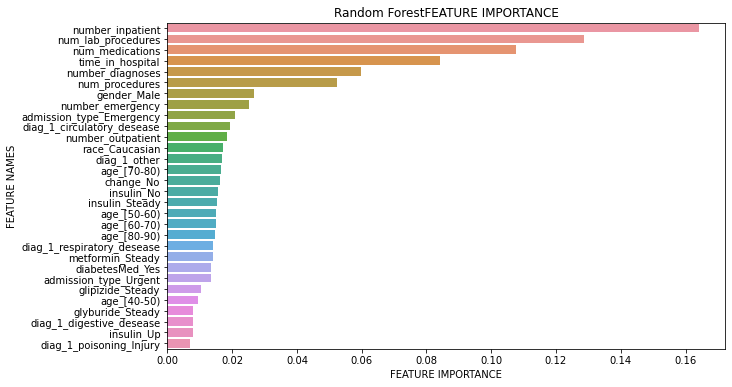

In [53]:
plot_feature_importance(forest.feature_importances_,X1.columns,"Random Forest")